# Random numbers example

**Table of contents**<a id='toc0_'></a>    
- 1. [Exchange economy with many consumers](#toc1_)    
  - 1.1. [Demand](#toc1_1_)    
  - 1.2. [Interactive figures](#toc1_2_)    
  - 1.3. [Equilibrium](#toc1_3_)    
- 2. [Numerical integration by Monte Carlo](#toc2_)    

<!-- vscode-jupyter-toc-config
	numbering=true
	anchor=true
	flat=false
	minLevel=2
	maxLevel=6
	/vscode-jupyter-toc-config -->
<!-- THIS CELL WILL BE REPLACED ON TOC UPDATE. DO NOT WRITE YOUR TEXT IN THIS CELL -->

This notebook will show how to use random numbers to simulate and solve a full equilibrium model with many heterogeneous agents.

In [1]:
import numpy as np

from scipy.stats import norm # normal distribution

%matplotlib inline
import matplotlib.pyplot as plt
plt.rcParams.update({"axes.grid":True,"grid.color":"black","grid.alpha":"0.25","grid.linestyle":"--"})
plt.rcParams.update({'font.size': 14})

import ipywidgets as widgets # For interactive plots/buttons

## 1. <a id='toc1_'></a>[Exchange economy with many consumers](#toc0_)

Consider an **exchange economy** with

1. 2 goods, $(x_1,x_2)$
2. $N$ consumers indexed by $j \in \{1,2,\dots,N\}$
3. Preferences are Cobb-Douglas with uniformly *heterogenous* coefficients

$$
\begin{aligned}
u^{j}(x_{1},x_{2}) & = x_{1}^{\alpha_{j}}x_{2}^{1-\alpha_{j}}\\
 & \,\,\,\alpha_{j}\sim\mathcal{U}(\underline{\mu},\overline{\mu})\\
 & \,\,\,0<\underline{\mu}<\overline{\mu}<1
\end{aligned}
$$

4. Endowments are *homogenous* and given by

$$
\boldsymbol{e}^{j}=(e_{1}^{j},e_{2}^{j})=(k,1),\,k>0
$$
where good 2 is *numeraire*.

Giving income $I$, with the following budget constriant:
\begin{equation}
I \equiv kp_1+ p_2 \geq x_1p_1 + x_2
\end{equation}

The implied **demand functions** are:

$$
\begin{aligned}
x_{1}^{\star j}(p_{1},p_{2},e^{j})&=&\alpha_{j}\frac{I}{p_{1}}=\alpha_{j}\frac{kp_{1}+p_{2}}{p_{1}} \\
x_{2}^{\star j}(p_{1},p_{2},e^{j})&=&(1-\alpha_{j})\frac{I}{p_{2}}=(1-\alpha_{j})\frac{kp_{1}+p_{2}}{p_{2}}
\end{aligned}
$$

The **equilibrium** for a random draw of $\alpha = \{\alpha_1,\alpha_2,\dots,\alpha_N\}$ is a set of **prices** $p_1$ and $p_2$ satifying:

$$
\begin{aligned}
x_1(p_1,p_2) = \underset{\text{Demand}}{\underbrace{\sum_{j=1}^N x_{1}^{\star j}(p_{1},p_{2},e^{j})}} &=  \underset{\text{Supply}}{\underbrace{\sum_{j=1}^N e_1^j}} = Nk \\
x_2(p_1,p_2) = \sum_{j=1}^N x_{2}^{\star j}(p_{1},p_{2},e^{j}) &= \sum_{j=1}^N e_2^j = N
\end{aligned}
$$

**Problem:** Solve for this equilibrium.  
But this requires a **distribution** of agents. Which means randomness.  
We need a random number generator (RNG)!

### 1.1. <a id='toc1_1_'></a>[Demand](#toc0_)

**Warm-up**: Choose parameters and define demand functions.

In [2]:
# a. parameters
N = 1000 # number of agents
k = 2 # relative endowment of good 1
mu_low = 0.1 # lower bound on alpha
mu_high = 0.9 # upper bound on alpha

# b. demand functions
def demand_good_1_func(alpha,p1,p2,k): #CHR: if we insert one alpha then it's the demand function for one person, however if you input a numpy array of alphas. see bottom note.
    I = k*p1+p2
    return alpha*I/p1

def demand_good_2_func(alpha,p1,p2,k):
    I = k*p1+p2
    return (1-alpha)*I/p2


# Notice that if an numpy array with multiple values where passed as the alpha argument, 
# the function would return demand for each value of alpha (using broadcasting).

Find demand distribution and total demand:

In [3]:
def find_demand_good_1(alphas,p1,p2,k):
    distr = demand_good_1_func(alphas,p1,p2,k) # Notice we are passing in arrays of alphas together with scalars! It works because of numpy broadcasting.
    total = np.sum(distr) #CHR: sums the demand
    return distr,total

Calculate for various prices:

In [4]:
# a. draw alphas
alphas = np.random.uniform(low=mu_low, high=mu_high, size=N)

# b. a set of hypothetical prices
p1_vec = [0.5,1,2,5] #CHR: Laver en vektor a 5 hypotetiske priser
p2 = 1

# c. calculate demand given prices
dists = np.empty((len(p1_vec),N)) #CHR: will be a 4xN matrix because we want the full distribution for each price.
totals = np.empty(len(p1_vec)) #CHR: will be a vector of the 4 values.
for i,p1 in enumerate(p1_vec):
    dist,total = find_demand_good_1(alphas,p1,p2,k) #CHR: We use the function
    dists[i,:] = dist #CHR: Distribution of demand for each alpha value, stored at the corresponding row index
    totals[i] = total #CHR: total demand across all alpha values, stored at the corresponding index

Plot the resulting demand given prices

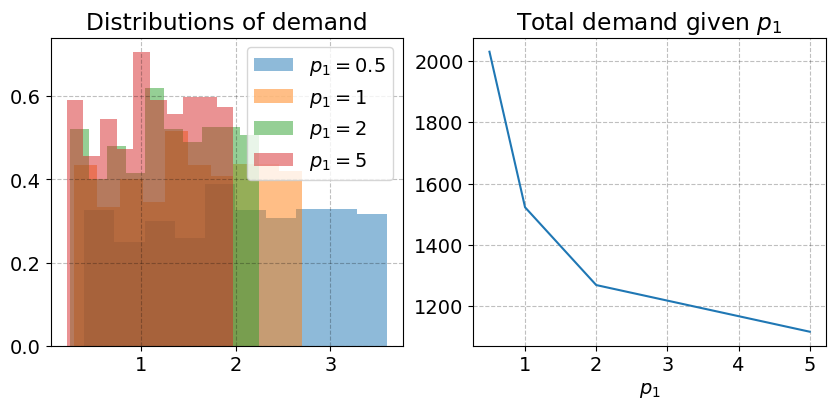

In [5]:
fig = plt.figure(figsize=(10,4))

ax_left = fig.add_subplot(1,2,1)
ax_left.set_title('Distributions of demand')
for i,p1 in enumerate(p1_vec):
    ax_left.hist(dists[i],density=True,alpha=0.5,label=f'$p_1 = {p1}$')
ax_left.legend(loc='upper right')

ax_right = fig.add_subplot(1,2,2)
ax_right.set_title('Total demand given $p_1$')
ax_right.grid(True)
ax_right.plot(p1_vec,totals)
ax_right.set_xlabel('$p_1$');

### 1.2. <a id='toc1_2_'></a>[Interactive figures](#toc0_)

Create a function constructing a figure, which can then be made interactive using [Jupyter widgets](https://ipywidgets.readthedocs.io/en/stable/) ([examples](https://ipywidgets.readthedocs.io/en/stable/examples/Widget%20List.html)):

In [6]:
# This function tells the widget how the plot should look at a specific parametrization 
def interactive_figure(alphas,p1,p2,k):
    
    # a. calculations
    dist,_total = find_demand_good_1(alphas,p1,p2,k)
    
    # b. figure
    fig = plt.figure(dpi=100)
    ax = fig.add_subplot(1,1,1)
    ax.hist(dist,density=True)
    ax.set_xlim([0,4]) # fixed x range
    ax.set_ylim([0,0.8]) # fixed y range
    ax.set_title("Distribution of demand for good 1")

**Case 1:** Make it interactive with a **slider**

In [7]:
# Write out which arguments to interactive_figure you want to be changing or staying fixed 
widgets.interact(interactive_figure,
    alphas=widgets.fixed(alphas),
    p1=widgets.FloatSlider(description=r"p1", min=0.1, max=5, step=0.05, value=2),
      #CHR: float slider is added so we can change the price of good 1.
      #specify name, minimum value, maximum value, how much it should move for each step, and what the initial value should be.
    p2=widgets.fixed(p2),
    k=widgets.fixed(k)
);

interactive(children=(FloatSlider(value=2.0, description='p1', max=5.0, min=0.1, step=0.05), Output()), _dom_c…

**Case 2:** Make it interactive with a **textbox**:

In [11]:
widgets.interact(interactive_figure,
    alphas=widgets.fixed(alphas),
    p1=widgets.FloatText(description=r"p1", value=2), #CHR: automatically has a clicker, but you can also just write a number.
    p2=widgets.fixed(p2),
    k=widgets.fixed(k)
);

interactive(children=(FloatText(value=2.0, description='p1'), Output()), _dom_classes=('widget-interact',))

**Case 3:** Make it interactive with a **dropdown menu**

In [12]:
widgets.interact(interactive_figure,
    alphas=widgets.fixed(alphas),
    p1=widgets.Dropdown(description="p1", options=[0.5,1,1.5,2.0,2.5,3], value=2),
    p2=widgets.fixed(p2),
    k=widgets.fixed(k)
);

interactive(children=(Dropdown(description='p1', index=3, options=(0.5, 1, 1.5, 2.0, 2.5, 3), value=2.0), Outp…

**Task:** Add a slider for $k$ to the interactive figure below.

In [15]:
# change this code
widgets.interact(interactive_figure,
    alphas=widgets.fixed(alphas),
    p1=widgets.FloatSlider(description="p1", min=0.1, max=5, step=0.05, value=2),
    p2=widgets.fixed(p2),
    k=widgets.FloatSlider(description="k", min=0, max = 5, step = 1,value = 2)
);

interactive(children=(FloatSlider(value=2.0, description='p1', max=5.0, min=0.1, step=0.05), FloatSlider(value…

### 1.3. <a id='toc1_3_'></a>[Equilibrium](#toc0_)

The equilibrium conditions were that **excess demand**, $Z$, is = 0 for both goods:

$$
\begin{aligned}
\sum_{j=1}^N x_{1}^{\star j}(p_{1},p_{2},e^{j}) &= Nk \Leftrightarrow Z_1 \equiv \sum_{j=1}^N x_{1}^{\star j}(p_{1},p_{2},e^{j}) - Nk = 0 \\
\sum_{j=1}^N x_{2}^{\star j}(p_{1},p_{2},e^{j}) &= N \Leftrightarrow Z_2 \equiv \sum_{j=1}^N x_{2}^{\star j}(p_{1},p_{2},e^{j}) - N = 0
\end{aligned}
$$

**Idea:** Solve just the first equation. Then the second is satisfied due to Walras's law.

**Algorithm:**  
First choose a tolerance $\epsilon > 0$ and an adjustment factor $\kappa>0$, and a guess on $p_1 > 0$. 
<br>\CHR: note we can't have $Z_1$ = 0 because of floating point inaccuracy 

Then find the equilibrium price by following iterative algorithm:

1. Calculate total excess demand of good 1: $Z_1 = \sum_{j=1}^N x_{1}^{\star j}(p_{1},p_{2},e^{j}) - Nk$
2. If $|Z_1| < \epsilon $ stop #CHR: If value is closer to 0 than tolerance parameter, then we just stop.
3. If $|Z_1| \geq \epsilon $ set $p_1 = p_1 + \kappa \cdot \frac{Z_1}{N}$ #CHR: if it is not closer to 0 than tolerance parameter, then we try a new guess, where we take our previous guess and change it in a way that is related to how much excess demand there was.
4. Return to step 1

**Intuition**  
If excess demand is **positive** and far from 0, then **increase** the price.  
If excess demand is **negative** and far from 0, then **decrease** the price.  

#CHR: note we can't have $Z_1$ = 0 because of floating point inaccuracy 

In [16]:
# Use the functions in module market_eq
%load_ext autoreload 
%autoreload 2
from market_eq import MarketEq

Finding the equilibrium price.  
See `market_eq.py` for implementation. 

In [17]:
N = 1000 # number of agents
k = 2 # relative endowment of good 1
mu_low = 0.1 # lower bound on alpha
mu_high = 0.9 # upper bound on alpha
kappa = 0.1 #no rule for how large kappa should be, should just be large enough so we actually adjust the price, but not too large so we overshoot (we jump too far)
eps = 1e-8

dale = MarketEq(N=N,k=k, mu_low=mu_low,mu_high=mu_high, kappa=kappa,eps=eps)


p1_guess = 1.5
p2 = 1
dale.find_equilibrium(p1_guess,p2)

  0: p1 =   1.50000000 -> excess demand ->  -661.50351790
  1: p1 =   1.43384965 -> excess demand ->  -646.06570452
  2: p1 =   1.36924308 -> excess demand ->  -629.54832980
  3: p1 =   1.30628824 -> excess demand ->  -611.88152522
  4: p1 =   1.24510009 -> excess demand ->  -592.99845716
   ...
 25: p1 =   0.54194731 -> excess demand ->   -69.95609355
 50: p1 =   0.50405706 -> excess demand ->    -0.33526208
 75: p1 =   0.50388810 -> excess demand ->    -0.00136234
100: p1 =   0.50388742 -> excess demand ->    -0.00000553
125: p1 =   0.50388742 -> excess demand ->    -0.00000002
129: p1 =   0.50388742 -> excess demand ->    -0.00000001


**Check:** Ensure that excess demand of both goods are (almost) zero.

In [18]:
dale.print_solution()

Solution to market equilibrium:
p1 = 0.504
p2 = 1.000

Excess demands are:
Z1 = -9.306859283242375e-09
Z2 = 4.689582056016661e-09


In [ ]:
print(dale.Z1,dale.Z2)
assert np.abs(dale.Z1) < eps
assert np.abs(dale.Z2) < eps

**Open task:**
1. Play around with the code and make sure you understand everything 
2. Play around with the parameters and see how stuff changes, which parameters breaks the solution?
3. How sensitive is the code e.g. to changes to the initial guess of $p_1$?
4. How sensitive is the code  e.g. to changes in $\kappa$?

If you have any questions you are very welcome to raise an issue on [github](https://github.com/NumEconCopenhagen/IntroProg-lectures/issues) with your question.

## 2. <a id='toc2_'></a>[Numerical integration by Monte Carlo](#toc0_)

Numerical integration is the task of computing

$$ 
\mathbb{E}[\mathbf{g}(x)]  \text{ where } x \sim F,
$$

where $F$ is a known probability distribution and $\mathbf{g}(\cdot)$ is a function. In terms of a integral this can also be writen as

$$
\mathbb{E}[\mathbf{g}(x)] = \int_{x\in\mathcal{X}} \mathbf{g}(x) dF(x) = \int_{x\in\mathcal{X}} \mathbf{g}(x) f(x) dx
$$

where $f$ is the PDF for the CDF $F$ and $\mathcal{X}$ is the domain of $x$.

In an economic model, $\mathbf{g}$ might represent the way the state of an agent or the economy develops stochastically. 

Relying on the law of large numbers we **approximate** the true integral with a finite sample:

$$
\mathbb{E}[\mathbf{g}(x)] \approx \frac{1}{N}\sum_{i=1}^{N} \mathbf{g}(x_i) 
$$

where $x_i$ is drawn from $F$ using a random number generator. This is also called **numerical integration by Monte Carlo**.

For an easy implementation, we use  

$$
\mathbf{g}(x) = (x-2)^2
$$

**Monte Carlo function:**  

In [19]:
def g(x):
    return (x-2)**2

def MC(N,g,F): #CHR: how many draws we want to do, what function we want to do, and then the distribution we want to do.
    X = F.rvs(size=N) # rvs = draw N random values from F
    return np.mean(g(X)) # apply g to X

**Example** with a normal distribution:

In [20]:
N = 1000
mu = 0.1
sigma = 0.5
F = norm(loc=mu,scale=sigma) #CHR: define the distribution
mc_integral = MC(N,g,F) #CHR: Insert into mean function and save it as mc_integral
print('E[g(x)] =', mc_integral)

E[g(x)] = 3.728757597951612


Function for drawning $ K $ Monte Carlo samples:

In [23]:
def MC_sample(N,g,F,K):
    
    results = np.empty(K)
    for i in range(K):
        results[i] = MC(N,g,F)

    return results

The variance across Monte Carlo samples falls with larger $N$:

In [22]:
K = 1000
for N in [10**2,10**3,10**4,10**5]:
    results = MC_sample(N,g,F,K)
    print(f'N = {N:8d}: {results.mean():.6f} (std: {results.std():.4f})')

N =      100: 3.857196 (std: 0.1970)
N =     1000: 3.860379 (std: 0.0608)
N =    10000: 3.859463 (std: 0.0192)
N =   100000: 3.859705 (std: 0.0061)


In principle, you can always use Monte Carlo. But if $\mathbf{g}$ had been a very computationally costly function, Monte Carlo would be infeasible. But there are other ways, which are a bit more advanced.